# 神经网络数字识别

这部分主要操作就是将从实验器件中获取的权重变化曲线导入到模型中，让模型的权重变化按照器件的权重变化曲线进行更行。

比如下图就是实验中突触器件的电导变化曲线，左侧蓝色部分为 potential，右侧黄色部分为 depression。

![](./img/%E5%AE%9E%E9%AA%8C%E6%95%B0%E6%8D%AE%E6%9B%B2%E7%BA%BF.png)

即模型的权重需要增加时，按照蓝色部分曲线进行更新，需要减小时按照黄色部分曲线进行更新。

注：**本文件中建立的神经网络为单层，并且为针对单个数字的训练**

![](./img/%E5%8D%95%E5%B1%82%E5%8D%95%E8%BE%93%E5%87%BA%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.png)

如果需要增加神经网络的层数，可以自行对 **4.神经网络主体部分** 中的内容进行修改。

*因为这里没有使用面向对象的方法进行建立模型，所以在修改层数以及输出层数量时会比较麻烦*

如果没有强制需求，不建议修改。

我在`data`文件夹中放了一份用于测试的权重数据，可以用来按照操作自行尝试一次。

## 1.模型前置

这一部分主要是导入第三方库，导入MNIST手写数字训练数据集等等，不需要动

In [46]:
# 导入第三方库

import numpy as np
from pathlib import Path
import struct
import matplotlib.pyplot as plt
import copy
import time
from scipy.optimize import curve_fit
import os
from rich.progress import track


# 读取MNIST手写数字数据集

dataset_path = Path("./MNIST")
train_img_path = dataset_path/'train-images-idx3-ubyte'
train_lab_path = dataset_path/'train-labels-idx1-ubyte'
test_img_path = dataset_path/'t10k-images-idx3-ubyte'
test_lab_path = dataset_path/'t10k-labels-idx1-ubyte'

with open(train_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    tmp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
    train_img = tmp_img[:]
with open(test_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(train_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    tmp_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
    train_lab = tmp_lab[:]
with open(test_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
# len(train_img)

# 用于显示数据集数字图片
# FUNCTION: show_image(index)
def show_image(img, index):
    plt.imshow(img[index].reshape(28, 28), cmap='gray')
    plt.pause(1)
    # print("label: {}".format(label[index]))
    return 0

下边单元格用于获取训练集和测试集的形状


![](./img/train_test_shape.png)

比如 `train_img.shape` 为 (60000, 784)，

这里的 60000 为训练集个数，即训练集中一共有 60000 个手写数字图片，784为 28*28，即单个样本所包含的数据量

因为这些图片都是 28*28 大小的，之前导入数据集时候已经将图片 flatten 为一维向量了

测试集 test 同理，但突触这里一般只用训练集训练即可，测试集一般不用，或者可以将测试集并入训练集一块用于训练模型（不知道如何操作可以不用改动）



In [47]:
# 这里获取训练集和测试集的矩阵形状

train_num = train_img.shape[0]
test_num = test_img.shape[0]
print(train_img.shape)
print(test_img.shape)
print(train_lab.shape)
train_lab

(60000, 784)
(10000, 784)
(60000, 1)


array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]], dtype=uint8)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([    3,     6,     8, ..., 59979, 59984, 59994], dtype=int64))
train set shape: (784, 60000)
train lab shape: (1, 60000)
test set shape: (784, 10000)
test lab shape: (1, 10000)


(-0.5, 27.5, 27.5, -0.5)

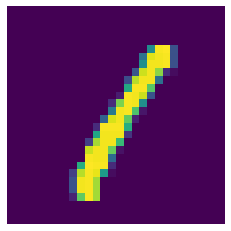

In [48]:
# 将给定num的label改为1
def train_setY(num):
    label = train_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label
def test_setY(num):
    label = test_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label

reg_num = 1 # 指定训练的数字

train_X = train_img.copy().T
train_Y = train_setY(reg_num).T
index_regnum = np.where(train_Y==1)
print(index_regnum)
test_X = test_img.copy().T
test_Y = test_setY(reg_num).T
print(f"train set shape: {train_X.shape}")
print(f"train lab shape: {train_Y.shape}")
print(f"test set shape: {test_X.shape}")
print(f"test lab shape: {test_Y.shape}")

# show_image(train_X.T, 1)
hw0 = train_X.T
i = index_regnum[1][0]
# np.save(f'handwritten{reg_num}.npy', hw0[i])
plt.imshow(hw0[i].reshape((28,28)))
plt.axis('off')
# np.savetxt(f'handwritten{reg_num}.txt', hw0[i])

**至此单元格以上的部分，直接运行即可。唯一需要注意的是 MNIST 文件夹需要和本文件放在同一个根目录下**

## 2.设置训练目标

这里设置模型所想要训练的数字。

比如我想训练模型对数字3的识别，只需要更改`reg_num`的值即可。

运行下边单元格会自动将`reg_num`所代表的数字对应的标签设置为$1$，其余数字的标签均设置为$0$。

如图为MNIST中某一个数字$3$的图像

![](./img/%E6%95%B0%E6%8D%AE%E9%9B%86%E4%B8%AD%E6%95%B0%E5%AD%973%E5%9B%BE%E5%83%8F.png)

## 3.导入权重变化曲线

这里需要导入实验上获取的权重数据了。

实验上一般是测对应器件的电导变化，使用另一个文件`fit_curve.ipynb`对曲线进行参数拟合，将对应参数输入到这里即可。

运行下边单元格会自动根据拟合参数绘制曲线。

类似于下图

![](./img/%E8%AE%BE%E7%BD%AE%E5%8F%82%E6%95%B0%E7%9A%84%E6%9D%83%E9%87%8D%E5%8F%98%E5%8C%96%E6%9B%B2%E7%BA%BF.png)

In [49]:
# 读取文件数据
def read_G(your_name):
    filepath= './data/'

    GD = []
    GP = []

    f_P = open(f"{filepath}{your_name}-GP.txt", 'r')
    f_D = open(f"{filepath}{your_name}-GD.txt", 'r')
    for each_P in f_P:
        GP.append(float(each_P.replace('\n', '')))
    for each_D in f_D:
        GD.append(float(each_D.replace('\n', '')))
    
    return abs(np.array(GP)), abs(np.array(GD))
# 进行拟合
def my_fit(your_name, save=False):
    
    GP_ori, GD_ori = read_G(your_name)

    # 归一化方法1：
    # GP_nor = GP_ori/max(GP_ori)
    # GD_nor = GD_ori/max(GD_ori)

    # 归一化方法2：
    # GP_nor = (GP_ori-min(GP_ori))/(max(GP_ori)-min(GP_ori))
    # GD_nor = (GD_ori-min(GD_ori))/(max(GD_ori)-min(GD_ori))

    # 归一化方法3：
    GP_nor = (GP_ori-min(GP_ori))/(max(GP_ori)-min(GP_ori))
    GD_nor = (GD_ori-min(GD_ori))/(max(GD_ori)-min(GD_ori))

    P = np.arange(1, int(len(GP_ori)), 1)
    D = np.arange(1, int(len(GD_ori)), 1)

    GPmax = max(GP_nor)
    GPmin = min(GP_nor)
    GDmax = max(GD_nor)
    GDmin = min(GD_nor)
    xP = GP_nor[:-1]
    yP = GP_nor[1:]
    xD = GD_nor[:-1]
    yD = GD_nor[1:]

    print(f'GP-max:{GPmax}, GP-min:{GPmin}')
    print(f'GD-max:{GDmax}, GD-min:{GDmin}')

    # 电导拟合公式 其中aP，aD为拟合参数，bP与bD为非线性度
    def delt_GP(xP, bP, aP):
        yP = xP + aP * np.exp(-bP * ((xP - GPmin) / (GPmax - GPmin)))
        return yP
    def delt_GD(xD, bD, aD):
        yD = xD + aD * np.exp(-bD * ((GDmax - xD) / (GDmax - GDmin)))
        return yD

    # 电导数据拟合
    np.random.seed(0)
    def curve_fit_GP(P, xP, yP, your_name, save=False, save_name='-GP'):
        # yP 段拟合数据
        while True:
            err_stdev = 0 # 0.2
            yP_noise = err_stdev * np.random.normal(size=yP.size)
            yP_data = yP + yP_noise
            popt, pcov = curve_fit(delt_GP, xP, yP_data)#训练函数
            bP = popt[0]
            aP = popt[1]
            if bP < 0:
                continue
            else:
                break
        yPvals=delt_GP(xP, bP, aP)
        plt.plot(P, yP, '*',label='original values')
        plt.plot(P, yPvals, 'r',label='curve_fit values')
        # plt.ylim(0, 1)
        plt.xlabel('P axis')
        plt.ylabel('GP axis')
        plt.legend(loc=4)
        plt.title(f"{your_name} curve_fit aP = %0.2f, bP = %0.2f" %(aP, bP))
        if save:
            plt.savefig(your_name + save_name + '.png', dpi=720)
            np.savetxt(your_name + save_name + '.txt', yPvals)
            print("GP-拟合图象与拟合数据已保存！")
        plt.show()
        return yPvals, GPmax, aP, bP
    def curve_fit_GD(D, xD, yD, your_name, save=False, save_name='-GD'):
        # yD 段拟合数据
        # while True:
        err_stdev = 0 # 0.2
        yD_noise = err_stdev * np.random.normal(size=xD.size)
        yD_data = yD + yD_noise
        popt, pcov = curve_fit(delt_GD, xD, yD_data)#训练函数
        bD = popt[0]
        aD = popt[1]
            # if bD < 0:
            #     continue
            # else:
            #     break
        yDvals=delt_GD(xD, bD, aD)
        plt.plot(D, yD, '*',label='original values')
        plt.plot(D, yDvals, 'r',label='curve_fit values')
        # plt.ylim(0,1)
        plt.xlabel('D axis')
        plt.ylabel('GD axis')
        plt.legend(loc=3)
        plt.title(f"{your_name} curve_fit aD = %0.2f, bD = %0.2f" %(aD, bD))
        if save:
            plt.savefig(your_name + save_name + '.png', dpi=720)
            np.savetxt(your_name + save_name + '.txt', yDvals)
            print("GD-拟合图象与拟合数据已保存！")
        plt.show()
        return yDvals, GDmax, aD, bD


    if save:
        np.savetxt(f"{your_name}-GP_nor.txt", GP_nor)
        np.savetxt(f"{your_name}-GD_nor.txt", GD_nor)
        print("归一化电导数据已保存！")

    yPvals, yP, aP, bP = curve_fit_GP(P, xP, yP, your_name, save)
    yDvals, yD, aD, bD = curve_fit_GD(D, xD, yD, your_name, save)
    return aP, bP, aD, bD

# 主函数
def main(save):
    your_name = input("请输入你的文件标识(如: 张三的'zs'))")
    aP, bP, aD, bD = my_fit(your_name, save)
    print("请自行记录下图片中拟合参数的数值！")
    return aP, bP, aD, bD

请输入你的文件标识(如: 张三的'zs'))lwl_1
GP-max:1.0, GP-min:0.0
GD-max:1.0, GD-min:0.0


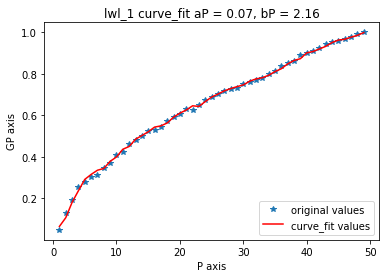

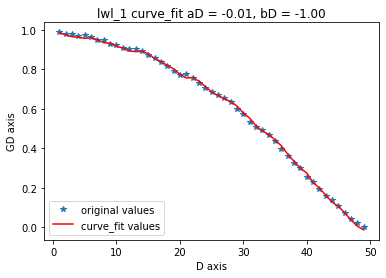

请自行记录下图片中拟合参数的数值！


In [50]:
aP, bP, aD, bD = main(save=False)

parameters = {
'a+': aP, 'b+': bP,
'a-': aD, 'b-': bD,
'wmax': 1, 'wmin': 0,
}

# print(yPvals)
# print(yDvals)

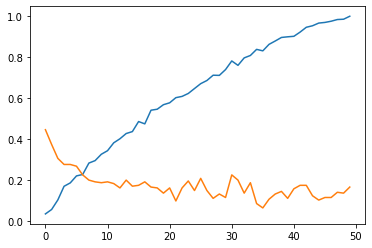

In [55]:
weight_plus_list = [parameters['wmin']]
weight_minus_list = [parameters['wmax']]

def weight_plus(w):
    delta_w = parameters['a+'] * np.exp(-parameters['b+']*(w-parameters['wmin'])
                                             /(parameters['wmax']-parameters['wmin']))
    return delta_w
def weight_minus(w):
    delta_w = parameters['a-'] * np.exp(-parameters['b-']*(parameters['wmax']-w)
                                             /(parameters['wmax']-parameters['wmin']))
    return delta_w
def equation():
    count_num = 0
    while True:
        weight_plus_list.append(weight_plus_list[-1]+weight_plus(weight_plus_list[-1]))
        weight_minus_list.append(weight_minus_list[-1]+weight_minus(weight_minus_list[-1]))
        count_num += 1
        if count_num == 50:
            break
        else:
            continue
    
    wpl = [(each - weight_plus_list[0]) / (weight_plus_list[-1]-weight_plus_list[0]) for each in weight_plus_list]
    wml = [(each - weight_minus_list[-1]) / (weight_minus_list[0]-weight_minus_list[-1]) for each in weight_minus_list]

    return np.array(wpl), np.array(wml)

# GP, GD = equation()

GP_ori = np.loadtxt('./data/lwl_2-GP.txt')
GD_ori = np.loadtxt('./data/lwl_2-GD.txt')

GP = GP_ori/max(max(GP_ori), max(GD_ori))
GD = GD_ori/max(max(GP_ori), max(GD_ori))

plt.plot(GP)
plt.plot(GD)
plt.show()

In [56]:
# 这里主要是建立模型权重与所导入的参数的联系
# 利用each_change函数来对更新权重进行处理

def findGP_num(data, find_array=GP):
    diff = abs(data - find_array)
    index = np.where(diff == np.min(diff))[0][0]
    # print(index)
    return find_array[index]

def findGD_num(data, find_array=GD):
    diff = abs(data - find_array)
    index = np.where(diff == np.min(diff))[0][0]
    return find_array[index]


# 可以利用G1-G2来实现-1~1的取值范围
def each_change(matrix_old, gradw, learning_rate):
    matrix_new = matrix_old.copy()
    for i in range(matrix_old.shape[0]):
        if gradw[i] < 0:
            # matrix_new[i] = matrix_old[i] + learning_rate*weight_plus(matrix_old[i])
            matrix_new[i] = findGP_num(matrix_old[i])
        elif gradw[i] > 0:
            matrix_new[i] = findGD_num(matrix_old[i])
            # matrix_new[i] = matrix_old[i] + learning_rate*weight_minus(matrix_old[i])
        else:
            matrix_new[i] = matrix_old[i]
    return matrix_new
# tmp = np.zeros((10, 1))
# each_change(tmp, [0]*len(tmp))

## 4.神经网络主体部分

这里是神经网络的主体，需要对神经网络模型有一定的了解。

如果需要修改层数，需要对应修改 参数初始化、向前传播、参数优化等等的内容

In [57]:
# 激活函数
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-1.0*z))
    return s

# 参数初始化
def initialize_with_zeros(seed, dim):
    # np.random.seed(seed)
    w = np.random.random((dim, 1)) * np.sqrt(2/dim)
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

# 向前传播
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1.0/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    dw = (1.0/m) * np.dot(X, (A-Y).T)

    db = (1.0/m) * np.sum(A-Y)

    Y_prediction = np.zeros((1, m))
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    accu = 100 - np.mean(np.abs(Y_prediction-Y)) * 100
    
#     print(f"(A-Y).shape: {(A-Y).shape}")
#     print(f"X.shape: {X.shape}")
#     print(f"w.shape: {w.shape}")
#     print(f"dw.shape: {dw.shape}")
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {
        "dw": dw,
        "db": db
    }
    
    return grads, cost, accu

# 参数优化
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    accus = []
    for i in track(range(num_iterations)):
        grads, cost, accu = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        # w = w - learning_rate * dw # 模型自身的更新权重方式
        b = b - learning_rate * db
        
        #######
        # 利用导入的曲线参数进行权重更新
        w = each_change(w, dw, learning_rate)
        # 让超出范围的权重重置
        w[np.where(w>1)] = 0
        w[np.where(w<0)] = 0
        #######

        # 每10次训练保存一次识别率
        if i%(10) == 0:
            costs.append(cost)
            accus.append(accu)
        
    params = {
        "w": w,
        "b": b
    }
    grads = {
        "dw": dw,
        "db": db
    }

    for each in range(len(accus)):
                
        if each%10 == 0:
            print("Cost after iterations %i: %f" %(each, costs[each]), end=' ')
            print(f"accu: {accus[each]}%")

    # return params, grads, costs
    return params, grads, accus

# 模型预测
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, seed, print_cost=False):
    w, b = initialize_with_zeros(seed, X_train.shape[0])
    # parameters, grads, costs= optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    parameters, grads, accus= optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_train-Y_train))*100))
    print("test accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_test-Y_test))*100))
    
    d = {
        "accus": accus,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    
    return d

## 5.运行

在前边单元格都运行后，就可以对模型进行训练了。

下边单元格中一般需要更改的为学习率`learning_rate`和`num_iterations`，前者控制权重更新步长，一般曲线波动较大可以适当缩小该值，后者控制模型训练多少次，默认1000次即可如果有需要可以自行更改训练次数。

在运行过程中会不断打印每100次训练后的`cost`与`accu`，即损失函数与识别准确率。如下图

![](./img/training_output.png)

运行完毕后会给出`train accuracy`和`test accuracy`的最终结果，并绘制训练过程中的识别率变化曲线，如下图。

![](./img/accuracy_example.png)

Output()

Number 3 Recognition:


Cost after iterations 0: 2.499317 accu: 10.218333333333334%
Cost after iterations 10: 0.482247 accu: 85.01666666666667%
Cost after iterations 20: 0.482247 accu: 85.02%
Cost after iterations 30: 0.482247 accu: 85.02%
Cost after iterations 40: 0.482247 accu: 85.02%
Cost after iterations 50: 0.482247 accu: 85.02%
Cost after iterations 60: 0.482247 accu: 85.02%
Cost after iterations 70: 0.482247 accu: 85.02%
Cost after iterations 80: 0.482247 accu: 85.02%
Cost after iterations 90: 0.482247 accu: 85.02%
train accuracy: 85.02%
test accuracy: 82.67%


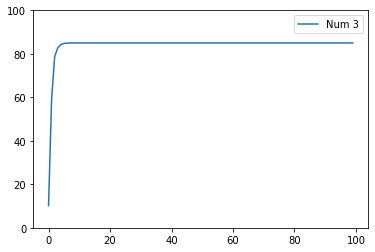

In [58]:
for reg_num in range(3, 4):

    train_X = train_img.copy().T
    train_Y = train_setY(reg_num).T
    index_regnum = np.where(train_Y==1)

    # 运行此单元格进行训练

    print(f"Number {reg_num} Recognition:")

    learning_rate=1 # 学习率：0~1
    num_iterations = 1000 # 训练次数

    d = model(train_X, train_Y, test_X, test_Y, seed=6, num_iterations=num_iterations, learning_rate=learning_rate, print_cost=False)

    accus = d["accus"].copy()
    
    plt.plot(accus, label=f'Num {reg_num}')

plt.ylim(0, 100) # 绘制识别率曲线时的y轴显示范围
plt.legend()
plt.show()

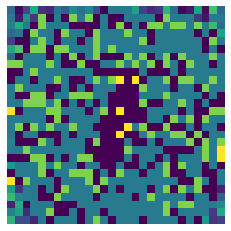

[0.] [0.06979106]


In [29]:
w = d["w"].copy()
plt.imshow(w.reshape((28,28)))
plt.axis('off')
plt.pause(0.1)
print(min(w), max(w))

## 6.保存数据

运行完上述所有单元格后，需不需要保存对应的数据文件就看个人需求了。

运行完毕后，所有数据均保存在字典`d`中，如图所示。

![](./img/%E5%AD%97%E5%85%B8d%E4%B8%AD%E7%9A%84%E6%95%B0%E6%8D%AE%E7%BB%93%E6%9E%84.png)

其中，
- `accus`保存的是整个训练过程中的准确率数据，每100次训练保存一次。
- `w`为训练完毕后，模型的权重
- `b`为训练完毕后，模型的偏置

一般需要的就是`accus`保存的数据，有时候如果矩阵`w`通过`plt.imshow()`能够绘制出较为清晰的数字的话，也可以保存一下，但一般不需要，自行选择。

In [ ]:
name = 'your_filename' # 在这里设置你要保存的文件名

np.savetxt(f"./output/{name} 数字{reg_num} 学习率{learning_rate}.txt", accus) # reg_num 对应前面的针对哪个数字训练

# 这里只需要设置name，运行完毕此单元格会自动将训练识别率数据保存为文件，命名格式为 “自己设置的名字 数字{训练数字} 学习率{本次训练中设置的学习率}.txt”

## 7.可视化权重矩阵

目前算法还存在一些问题。

比如如果使用突触器件的数据进行训练，权重矩阵可视化后一般看不出数字的样子。下图中勉强能看到数字3的轮廓

![](./img/%E6%A8%A1%E5%9E%8B%E8%AE%AD%E7%BB%83%E5%90%8E%E7%9A%84%E6%95%B0%E5%AD%973.png)

In [ ]:
w = d["w"].copy()
# w[np.where(w<0)] = 0
plt.imshow(w.reshape((28,28)))
plt.axis('off')
plt.pause(0.1)

# 如果想要保存本次训练的权重数据，将下面一行取消注释并运行即可，文件会命名为 “name w{识别的数字}_aftertrain”，要注意是否会和之前保存的文件冲突而导致覆盖丢失数据
# np.savetxt(f"./output/{name} w{reg_num}_aftertrain.txt", w.reshape((28,28)))
